In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('order_brush_order.csv')

In [3]:
df.head()
res = dict()
# res shape should be 18770 * 2
remain_answer_shop = 18770

## Get unique shop id 

In [4]:
print(df.shape)
print("number of shop id: ", df['shopid'].nunique())
print("number of user id: ", df['userid'].nunique())
remain_answer_shop = df['shopid'].nunique()
unique_shopId = df['shopid'].unique()
unique_userId = df['userid'].unique()
print("unique shop id: ", unique_shopId, len(unique_shopId))
print("unique user id: ", unique_userId, len(unique_userId))

(222750, 4)
number of shop id:  18770
number of user id:  93883
unique shop id:  [ 93950878 156423439 173699291 ...  50236030 203587596 147118226] 18770
unique user id:  [30530270 46057927 67341739 ... 55114470 41654255 27306783] 93883


## Filtered by buyers less than 3

In [5]:
group_shop = df.groupby(['shopid'])
filter_shopId = []
for i, shopId in enumerate(unique_shopId):
    if group_shop.get_group(shopId).shape[0] < 3:
        res[shopId] = 0
        filter_shopId.append(shopId)
unique_shopId = [item for item in unique_shopId if item not in filter_shopId]
print("Got number of answers: ", len(res), "remain answers: ", len(unique_shopId), len(res)+len(unique_shopId) == remain_answer_shop)

Got number of answers:  9739 remain answers:  9031 True


## Filter each shop by count number of each userid which less than 2

In [6]:
# sort event time in df
freqCount = 0
filter_shopId = []
for i, uid in enumerate(unique_shopId):
    testdf = group_shop.get_group(uid).sort_values(["event_time"])
    userfreq = testdf['userid'].value_counts()
    if userfreq.max() >= 3:
        freqCount += 1
    else:
        res[uid] = 0
        filter_shopId.append(uid)
unique_shopId = [item for item in unique_shopId if item not in filter_shopId]
print("Got number of answers: ", len(res), "remain answers: ", len(unique_shopId), len(res)+len(unique_shopId) == remain_answer_shop)

Got number of answers:  17942 remain answers:  828 True


## Get user dataframe from specific shop dataframe

In [7]:
testdf = group_shop.get_group(unique_shopId[0]).sort_values(["event_time"])
userfreq = testdf['userid'].value_counts()
numberCandicate, candicates = userfreq[userfreq >=3].index.shape[0], np.array(userfreq[userfreq >=3].index)

subtestdf = testdf[testdf['userid'] == candicates[0]].sort_values(["event_time"])
print("number of candicate user id: ", numberCandicate)
print("candicate userids: ",candicates)
print(subtestdf)

number of candicate user id:  1
candicate userids:  [110240400]
              orderid     shopid     userid           event_time
43418  31280563745641  173699291  110240400  2019-12-29 09:02:43
30408  31387219757278  173699291  110240400  2019-12-30 14:40:19
49832  31387324931487  173699291  110240400  2019-12-30 14:42:05


### Note: How to calculate datetime

In [8]:
import datetime
from dateutil.parser import parse
now = datetime.datetime.now()
print(now)
a = parse('January 31, 2010')
print(a)
td = datetime.timedelta(weeks=1, days=30, hours=2, minutes=40)
print(td)
t1 = parse(group_shop.get_group(unique_shopId[0]).sort_values(["event_time"]).iloc[0]['event_time'])
t2 = parse(group_shop.get_group(unique_shopId[0]).sort_values(["event_time"]).iloc[1]['event_time'])
oneHour = datetime.timedelta(hours=1)
print(t1)
print(t2)
print(t2-t1)

print(oneHour)
print((t2-t1) < oneHour)

2021-02-26 11:20:57.353621
2010-01-31 00:00:00
37 days, 2:40:00
2019-12-27 00:48:28
2019-12-27 01:00:48
0:12:20
1:00:00
True


## Get candicates which equal to 3 and difference between start and end time >one hour

In [9]:
oneHour = datetime.timedelta(hours=1)
subTables = []
filter_shopId = []
for i, uid in enumerate(unique_shopId):
    testdf = group_shop.get_group(uid)
    userfreq = testdf['userid'].value_counts()
    numberCandicate = userfreq[userfreq >=3].index.shape[0]
    candicates = np.array(userfreq[userfreq >=3].index)
    
    if(numberCandicate == 1):
        subtestdf = testdf[testdf['userid'] == candicates[0]].sort_values(["event_time"])
        if(subtestdf.shape[0] == 3):
            startT = parse(subtestdf.iloc[0]['event_time'])
            endT = parse(subtestdf.iloc[-1]['event_time'])
            if((endT-startT) > oneHour):
                res[uid] = 0
                filter_shopId.append(uid)

    
unique_shopId = [item for item in unique_shopId if item not in filter_shopId]
print("Got number of answers: ", len(res), "remain answers: ", len(unique_shopId), len(res)+len(unique_shopId) == remain_answer_shop)

Got number of answers:  18255 remain answers:  515 True


## Filter candicates which equal to 3 and difference between start and end time >one hour

### Condition: number of candicate == 0,  

In [10]:
subTables = []
filter_shopId = []
for i, uid in enumerate(unique_shopId):
    testdf = group_shop.get_group(uid)
    userfreq = testdf['userid'].value_counts()
    candicates = np.array(userfreq[userfreq >=3].index)
    filter_candicates = []
    
    for user in candicates:
        subtestdf = testdf[testdf['userid'] == user].sort_values(["event_time"])
        if(subtestdf.shape[0] == 3):
            startT = parse(subtestdf.iloc[0]['event_time'])
            endT = parse(subtestdf.iloc[-1]['event_time'])
            if((endT-startT) > oneHour):
                filter_candicates.append(user)
    candicates = [c for c in candicates if c not in filter_candicates]
    if len(candicates) == 0:
        res[uid] = 0
        filter_shopId.append(uid)
    else:
        subTables.append({'shopid': uid,
                     "candicates": candicates})

unique_shopId = [item for item in unique_shopId if item not in filter_shopId]
print("Got number of answers: ", len(res), "remain answers: ", len(unique_shopId), len(res)+len(unique_shopId) == remain_answer_shop)

Got number of answers:  18281 remain answers:  489 True


In [11]:
subTables = sorted(subTables, key=lambda k: len(k['candicates'])) 
print(len(subTables))

489


## The column index (start time and end time) is continue, order brushing

In [12]:
filter_shopId = []
count = 0
for s in subTables:
    testdf = group_shop.get_group(s['shopid']).sort_values(["event_time"])
    testdf['time'] = [parse(testdf.iloc[i]['event_time']) for i in range(testdf.shape[0])]
    testdf.reset_index(drop=True, inplace=True)
    if(len(s['candicates']) == 1):
        subtestdf = testdf[testdf['userid'] == s['candicates'][0]].sort_values(["time"])
        startT = subtestdf.iloc[0]['time']
        endT = subtestdf.iloc[-1]['time']
        if ((endT-startT) < oneHour):
            startIdx = testdf[testdf['time'] == startT].index.values[0]
            endIdx = testdf[testdf['time'] == endT].index.values[0]
            if((endIdx - startIdx + 1) == subtestdf.shape[0]):
                res[s['shopid']] = s['candicates'][0]
                filter_shopId.append(s['shopid'])
                count += 1
                

unique_shopId = [item for item in unique_shopId if item not in filter_shopId]
print("Got number of answers: ", len(res), "remain answers: ", len(unique_shopId), len(res)+len(unique_shopId) == remain_answer_shop)
subTables = [t for t in subTables if t["shopid"] not in filter_shopId]
print(len(subTables))

Got number of answers:  18542 remain answers:  228 True
228


In [13]:
filter_shopId = []
for s in subTables:
    testdf = group_shop.get_group(s['shopid']).sort_values(["event_time"])
    testdf['time'] = [parse(testdf.iloc[i]['event_time']) for i in range(testdf.shape[0])]
    testdf.reset_index(drop=True, inplace=True)
    if(len(s['candicates']) == 1):
        subtestdf = testdf[testdf['userid'] == s['candicates'][0]].sort_values(["time"])
        startT = subtestdf.iloc[0]['time']
        endT = subtestdf.iloc[-1]['time']
        if ((endT-startT) < oneHour):
            startIdx = testdf[testdf['time'] == startT].index.values[0]
            endIdx = testdf[testdf['time'] == endT].index.values[0]
#             print(testdf.loc[startIdx:endIdx][["userid", "time"]])
            subTestdf = testdf.loc[startIdx:endIdx]
            uniqueUser = subTestdf['userid'].nunique()
            numOders = subTestdf.shape[0]
            isOderBrushing = (numOders/uniqueUser) >=3
            if isOderBrushing:
                res[s['shopid']] = s['candicates'][0]
                filter_shopId.append(s['shopid'])
            else:
                res[s['shopid']] = 0
                filter_shopId.append(s['shopid'])
#             print(subtestdf.shape[0], startIdx, endIdx, uniqueUser, numOders,isOderBrushing, numOders/uniqueUser)

unique_shopId = [item for item in unique_shopId if item not in filter_shopId]
print("Got number of answers: ", len(res), "remain answers: ", len(unique_shopId), len(res)+len(unique_shopId) == remain_answer_shop)
subTables = [t for t in subTables if t["shopid"] not in filter_shopId]
print(len(subTables))

Got number of answers:  18577 remain answers:  193 True
193


           orderid     shopid    userid           event_time  \
0   31116288781532  195394274  50496873  2019-12-27 11:24:48   
1   31124581598693  195394274  50496873  2019-12-27 13:43:01   
2   31127254106109  195394274  50496873  2019-12-27 14:27:35   
15  31475884094952  195394274  50496873  2019-12-31 15:18:04   

                  time  
0  2019-12-27 11:24:48  
1  2019-12-27 13:43:01  
2  2019-12-27 14:27:35  
15 2019-12-31 15:18:04  


AssertionError: 

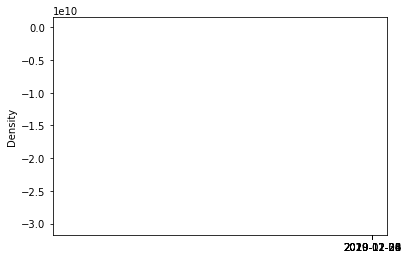

In [34]:
import time
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot
for s in subTables:
    testdf = group_shop.get_group(s['shopid']).sort_values(["event_time"])
    testdf['time'] = [parse(testdf.iloc[i]['event_time']) for i in range(testdf.shape[0])]
    testdf.reset_index(drop=True, inplace=True)
    if(len(s['candicates']) == 1):
        subtestdf = testdf[testdf['userid'] == s['candicates'][0]].sort_values(["time"])
        startT = subtestdf.iloc[0]['time']
        endT = subtestdf.iloc[-1]['time']

        print(subtestdf)
#         print((endT-startT), subtestdf.shape[0])
        
        subtestdf['ordinal'] = subtestdf['time'].apply(lambda t: t.toordinal() )
#         subtestdf['ordinal'] = subtestdf['time'].apply(lambda t: t.timestamp() )
#         subtestdf.groupby(subtestdf["time"].dt.day)["time"].count().plot(kind="bar")
        
        ax = subtestdf['ordinal'].plot(kind='kde')
        # rename the xticks with labels
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks[::2])
        xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
#         xlabels = [time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(x / 1000.0)) for x in x_ticks[::2]]
        ax.set_xticklabels(xlabels)
        timeTest = np.array(subtestdf['ordinal']).reshape(-1, 1)
        kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(timeTest)
        s = np.linspace(0,10)
        e = kde.score_samples(s.reshape(-1,1))
        plot(s, e)
        
        assert(0)
        